In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Config, GPT2Model
from tqdm import tqdm

# Check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device("cpu")
    print("Using MPS device")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"MPS not available, using device: {device}")

# # Custom configuration
# config = GPT2Config(
#     vocab_size=1001,  # 0-9 digits + special token
#     n_positions=22,  # Input sequence (11) + Output sequence (11)
#     n_ctx=22,
#     n_embd=64,
#     n_layer=1,
#     n_head=2,
#     bos_token_id=1000,
#     eos_token_id=1000,
# )

# class SortingTransformer(nn.Module):
#     def __init__(self, config):
#         super().__init__()
#         self.transformer = GPT2Model(config)
#         self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

#     def forward(self, input_ids, attention_mask=None):
#         transformer_outputs = self.transformer(input_ids, attention_mask=attention_mask)
#         hidden_states = transformer_outputs[0]
#         lm_logits = self.lm_head(hidden_states)
#         return lm_logits

class SortingDataset(Dataset):
    def __init__(self, size=1000, seq_length=10):
        self.size = size
        self.seq_length = seq_length

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        sequence = torch.randint(0, 1000, (self.seq_length,), device=device)
        sorted_sequence = torch.sort(sequence)[0]
        
        # Construct target: [BOS, sequence, BOS, sorted_sequence, EOS]
        target_ids = torch.full((22,), 1000, device=device)  # Initialize with BOS/EOS token
        target_ids[1:11] = sequence
        target_ids[11] = 1000  # BOS token to separate input and output
        target_ids[12:22] = sorted_sequence
        
        return target_ids

Using MPS device


In [2]:
# Create dataset and dataloader
dataset = SortingDataset()
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [3]:
from tqdm import tqdm

def train(model, dataloader, optimizer, num_epochs=10):
    model.train()
    criterion = nn.CrossEntropyLoss()
    
    epoch_losses = []
    
    for epoch in range(num_epochs):
        total_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch, target_ids in enumerate(progress_bar):
            optimizer.zero_grad()

            input_ids = target_ids[..., :-1]
            output_ids = target_ids[..., 11:]
            
            outputs = model(input_ids)[..., -11:, :]
            loss = criterion(outputs.reshape(-1, model.cfg.d_vocab), output_ids.reshape(-1))
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

            if batch%100 == 1:
                progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})
        
        avg_loss = total_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}")
    
    return epoch_losses

In [4]:
def sort_sequence(model, sequence):
    model.eval()
    with torch.no_grad():
        # Prepare input: [BOS, sequence, BOS, zeros]
        input_ids = torch.full((1, 22), 1000, device=device)  # Initialize with BOS/EOS token
        input_ids[0, 1:11] = sequence
        print(input_ids)
        
        # Generate sorted sequence
        for i in range(11, 22):
            outputs = model(input_ids[:, :i])
            next_token = outputs[0, -1, :].argmax()
            input_ids[0, i] = next_token
        
        sorted_sequence = input_ids[0, -10:].cpu()
    
    return sorted_sequence

In [5]:
from transformer_lens import HookedTransformer, HookedTransformerConfig

hooked_config = HookedTransformerConfig(
    n_layers=1,
    d_model=64,
    n_ctx=22,
    d_head=64,
    attn_only=True,
    d_vocab=1001,
    device=device,
    act_fn="gelu_new",
    normalization_type=None,
)

hooked_model = HookedTransformer(hooked_config)

hooked_model.unembed.W_U.data = hooked_model.embed.W_E.T

In [6]:
path = "models/tiny_sort_0.pt"
checkpoint = torch.load(path, weights_only=True)
hooked_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [343]:
# Create dataset and dataloader
dataset = SortingDataset(size=100000)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# # Initialize model and optimizer
# model = SortingTransformer(config).to(device)
optimizer = optim.Adam(hooked_model.parameters(), lr=1e-3)

train(hooked_model, dataloader, optimizer, 5)
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-4
train(hooked_model, dataloader, optimizer, 5)

seq = torch.randint(0, 1000, (10,))
sorted_seq = sort_sequence(hooked_model, seq)
expected_sequence = seq.sort().values
print(f"Original sequence: {seq}")
print(f"Sorted sequence:   {sorted_seq}")
print(f"Expected sequence: {expected_sequence}")

# 1.76 with 2L 2H 32 d_model

Epoch 1/5: 100%|██████████████| 3125/3125 [00:07<00:00, 423.42it/s, loss=1.0137]


Epoch 1 completed. Average Loss: 2.4022


Epoch 2/5: 100%|██████████████| 3125/3125 [00:07<00:00, 438.55it/s, loss=0.5199]


Epoch 2 completed. Average Loss: 0.7445


Epoch 3/5: 100%|██████████████| 3125/3125 [00:07<00:00, 422.73it/s, loss=0.5236]


Epoch 3 completed. Average Loss: 0.5180


Epoch 4/5: 100%|██████████████| 3125/3125 [00:07<00:00, 422.60it/s, loss=0.3130]


Epoch 4 completed. Average Loss: 0.4024


Epoch 5/5: 100%|██████████████| 3125/3125 [00:07<00:00, 436.81it/s, loss=0.2691]


Epoch 5 completed. Average Loss: 0.3262


Epoch 1/5: 100%|██████████████| 3125/3125 [00:07<00:00, 442.60it/s, loss=0.2285]


Epoch 1 completed. Average Loss: 0.2349


Epoch 2/5: 100%|██████████████| 3125/3125 [00:07<00:00, 434.52it/s, loss=0.2770]


Epoch 2 completed. Average Loss: 0.2162


Epoch 3/5: 100%|██████████████| 3125/3125 [00:07<00:00, 421.46it/s, loss=0.2185]


Epoch 3 completed. Average Loss: 0.2070


Epoch 4/5: 100%|██████████████| 3125/3125 [00:07<00:00, 433.39it/s, loss=0.1590]


Epoch 4 completed. Average Loss: 0.2011


Epoch 5/5: 100%|██████████████| 3125/3125 [00:08<00:00, 365.91it/s, loss=0.1982]

Epoch 5 completed. Average Loss: 0.1962
tensor([[1000,  199,  553,  256,  803,  899,  110,  975,  845,  553,    3, 1000,
         1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]])
Original sequence: tensor([199, 553, 256, 803, 899, 110, 975, 845, 553,   3])
Sorted sequence:   tensor([  3, 110, 199, 256, 553, 553, 803, 845, 899, 975])
Expected sequence: tensor([  3, 110, 199, 256, 553, 553, 803, 845, 899, 975])


In [344]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-5
train(hooked_model, dataloader, optimizer, 5)

Epoch 1/5: 100%|██████████████| 3125/3125 [00:07<00:00, 444.41it/s, loss=0.2062]


Epoch 1 completed. Average Loss: 0.1899


Epoch 2/5: 100%|██████████████| 3125/3125 [00:07<00:00, 416.21it/s, loss=0.1497]


Epoch 2 completed. Average Loss: 0.1871


Epoch 3/5: 100%|██████████████| 3125/3125 [00:07<00:00, 402.58it/s, loss=0.1869]


Epoch 3 completed. Average Loss: 0.1845


Epoch 4/5: 100%|██████████████| 3125/3125 [00:08<00:00, 386.33it/s, loss=0.2671]


Epoch 4 completed. Average Loss: 0.1864


Epoch 5/5: 100%|██████████████| 3125/3125 [00:08<00:00, 371.17it/s, loss=0.1520]

Epoch 5 completed. Average Loss: 0.1848


[0.18994617861151694,
 0.18714802790045737,
 0.1844696359682083,
 0.18637780178308486,
 0.18478384089231492]

In [549]:
# path = "models/tiny_sort_1.pt"

# torch.save(hooked_model.state_dict(), path)

In [7]:
seq = torch.randint(0, 1000, (10,))
sorted_seq = sort_sequence(hooked_model, seq)
expected_sequence = seq.sort().values
print(f"Original sequence: {seq}")
print(f"Sorted sequence:   {sorted_seq}")
print(f"Expected sequence: {expected_sequence}")

tensor([[1000,  946,  240,  745,  316,  741,  830,  467,  145,  888,  608, 1000,
         1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]])
Original sequence: tensor([946, 240, 745, 316, 741, 830, 467, 145, 888, 608])
Sorted sequence:   tensor([145, 240, 316, 467, 608, 745, 745, 830, 888, 946])
Expected sequence: tensor([145, 240, 316, 467, 608, 741, 745, 830, 888, 946])


In [8]:
import circuitsvis as cv

def get_random_seq():
    sequence = torch.randint(0, 1000, (10,))
    sorted_sequence = torch.sort(sequence)[0]
    
    target_ids = torch.full((22,), 1000)
    target_ids[1:11] = sequence
    target_ids[12:22] = sorted_sequence

    return target_ids

seq = get_random_seq()
seq

tensor([1000,  734,  848,  698,  357,  673,   99,  353,  758,  143,   37, 1000,
          37,   99,  143,  353,  357,  673,  698,  734,  758,  848])

In [76]:
def tok_to_str(token_ids):
    return list(map(str, token_ids.cpu().tolist()))

# test_seq = torch.arange(50, 1000, 100)
test_seq = torch.tensor([0, 100, 150, 200, 250, 750, 800, 850, 900, 950])
# test_seq = torch.tensor([150, 100, 850, 750, 200, 250, 900, 0, 800, 950])
# test_seq = torch.tensor([0, 100, 150, 200, 230, 245, 250, 250, 250, 950])
# test_seq = torch.tensor([0, 50, 800, 820, 840, 860, 880, 900, 920, 950])

seq[1:11] = test_seq
seq[12:] = torch.sort(test_seq)[0]
# seq[1:11] = seq[12:]
# seq[1:11] = torch.flip(seq[12:], (0,))

logits, cache = hooked_model.run_with_cache(seq)

strs = tok_to_str(seq)
attention_pattern = cache["pattern", 0, "attn"]
print(strs)
print(attention_pattern.shape)

cv.attention.attention_patterns(tokens=strs, attention=attention_pattern[0])

['1000', '0', '100', '150', '200', '250', '750', '800', '850', '900', '950', '1000', '0', '100', '150', '200', '250', '750', '800', '850', '900', '950']
torch.Size([1, 1, 22, 22])


In [10]:
def get_resid_component_logits(component):
    return (component @ hooked_model.unembed.W_U + hooked_model.unembed.b_U)[0]

def print_str_vals(strs, vals):
    for s, val in zip(strs, vals):
        print(f"{s}: {val:.4f}")

attn_logits = get_resid_component_logits(cache["attn_out", 0])
print_str_vals(strs, attn_logits.argmax(1))

1000: 1000.0000
0: 1000.0000
100: 1000.0000
150: 1000.0000
200: 1000.0000
250: 1000.0000
750: 1000.0000
800: 0.0000
850: 1000.0000
900: 789.0000
950: 1000.0000
1000: 0.0000
0: 100.0000
100: 150.0000
150: 200.0000
200: 250.0000
250: 750.0000
750: 800.0000
800: 850.0000
850: 900.0000
900: 950.0000
950: 0.0000


tokens attend to:
- strongly the next greatest number (unsorted)
- their unsorted counterpart
- smaller numbers (unsorted)

the 250 token attends most strongly to it's unsorted counterpart, 800, then 750. How does it predict 750?
- maybe it attends to itself (current token) weakly?


In [11]:
# let's look directly at the attention pattern for the sorted 250 token

print_str_vals(strs, attention_pattern[0, 0, 16, :])

1000: 0.0011
0: 0.0008
100: 0.0094
150: 0.0122
200: 0.0904
250: 0.3005
750: 0.1823
800: 0.2644
850: 0.0771
900: 0.0254
950: 0.0034
1000: 0.0312
0: 0.0000
100: 0.0000
150: 0.0000
200: 0.0003
250: 0.0015
750: 0.0000
800: 0.0000
850: 0.0000
900: 0.0000
950: 0.0000


it does attend to itself slightly. Is this used in the OV circuit?

can verify by zeroing out the attention pattern for this token and running forward pass. How does this change logits?

In [13]:
def get_attn_outputs_from_pattern(pattern, attn):
    # V = cache['embed'] @ attn.W_V + attn.b_V # this doesn't work for some reason? ->>> I forgot pos embeddings
    V = cache['v', 0]
    weighted_V = V * pattern[None, :, None, None]
    z = weighted_V.sum(dim=1)
    attn_out = z @ attn.W_O + attn.b_O
    return attn_out

attn = hooked_model.blocks[0].attn
my_attn_out = get_attn_outputs_from_pattern(attention_pattern[0, 0, 16, :], attn)
cache_attn_out = cache['attn_out', 0][0, 16, :]

torch.allclose(my_attn_out, cache_attn_out)

# my function works! Now I can compute attn_out logits with a custom pattern.

True

In [14]:
get_resid_component_logits(my_attn_out).argmax()

tensor(750)

In [15]:
attention_pattern[0, 0, 16, :]

tensor([1.1461e-03, 8.0504e-04, 9.4002e-03, 1.2245e-02, 9.0367e-02, 3.0045e-01,
        1.8227e-01, 2.6435e-01, 7.7083e-02, 2.5382e-02, 3.4419e-03, 3.1220e-02,
        3.9445e-06, 2.9355e-05, 2.8642e-05, 2.9035e-04, 1.4864e-03, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])

In [20]:
import plotly.express as px
import pandas as pd

In [77]:
labels = [f"{s}_{i}" for i, s in enumerate(strs)]

def graph_attn_out_diff(orig_pat, modified_pat):
    df = pd.DataFrame({
        'labels': labels + labels,
        'attn_pattern': orig_attn_pat.tolist() + modified_pat.tolist(),
        'group': ["orig"] * len(labels) + ["mod"] * len(labels),
    })
    
    px.bar(df, x='labels', y='attn_pattern', color='group', barmode='group', log_y=False).show()
    
    orig_attn_out = get_attn_outputs_from_pattern(orig_attn_pat, attn)
    mod_attn_out = get_attn_outputs_from_pattern(modified_pat, attn)
    orig_logits = get_resid_component_logits(orig_attn_out)
    mod_logits = get_resid_component_logits(mod_attn_out)
    
    px.line(orig_logits[0].tolist()).show()
    px.line(mod_logits[0].tolist()).show()

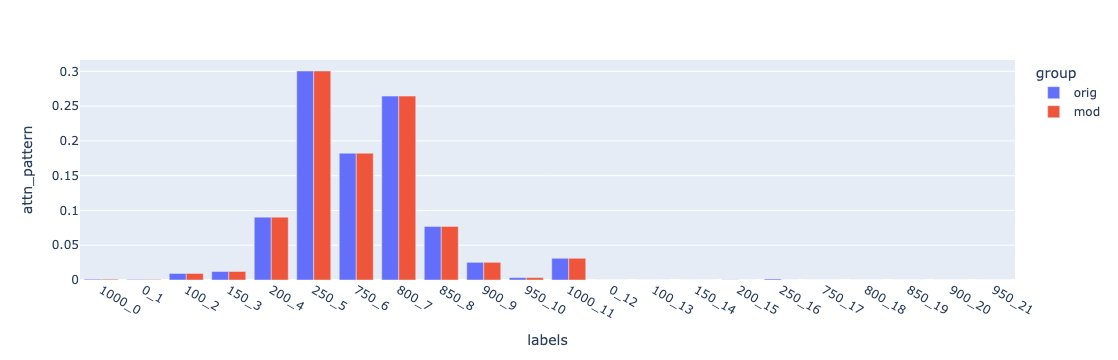

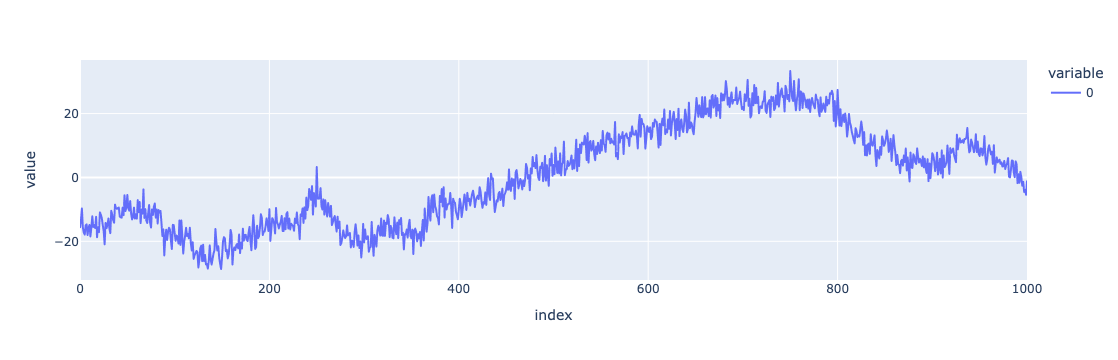

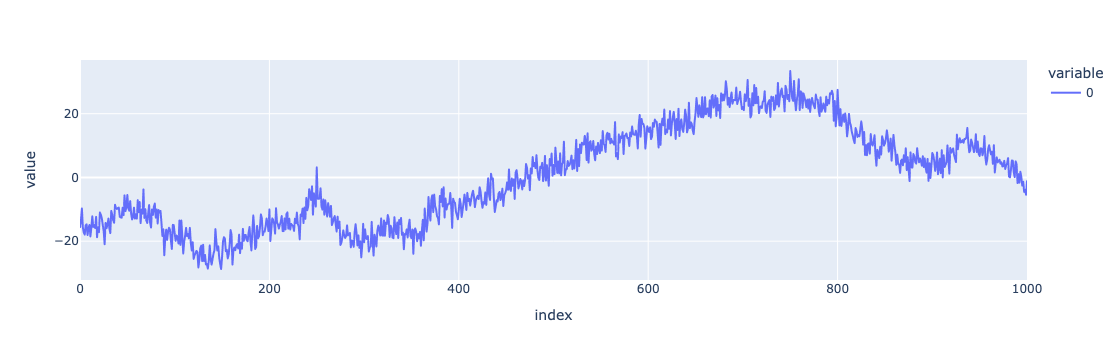

In [78]:
orig_attn_pat = attention_pattern[0, 0, 16, :]
my_attn_pat = attention_pattern[0, 0, 16, :].clone()
my_attn_pat[12:17] = 0

graph_attn_out_diff(orig_attn_pat, my_attn_pat)

In [48]:
(orig_logits - mod_logits).argmax()

tensor(250)

Looks like ablating the sorted values doesn't do anything. Somehow, the correct token is still predicted.

- there must be some way the model is deriving the current position without looking at the current token. maybe this is the BOS token?

tensor([0.0000, 0.0008, 0.0094, 0.0122, 0.0904, 0.3005, 0.1823, 0.2644, 0.0771,
        0.0254, 0.0034, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])


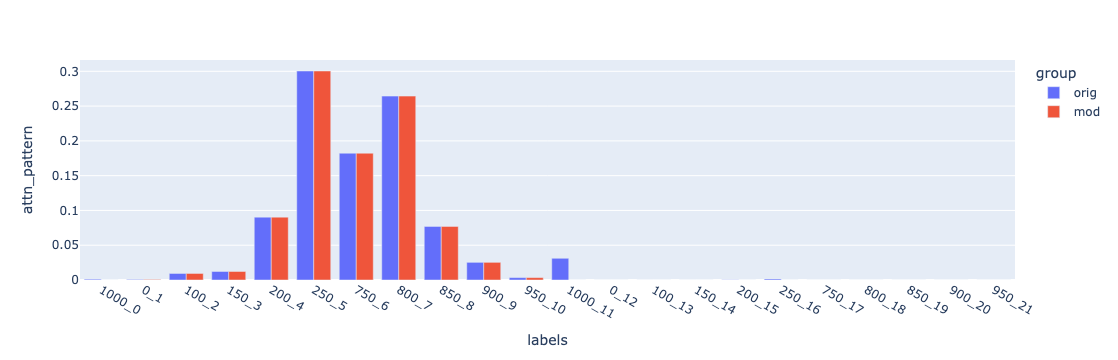

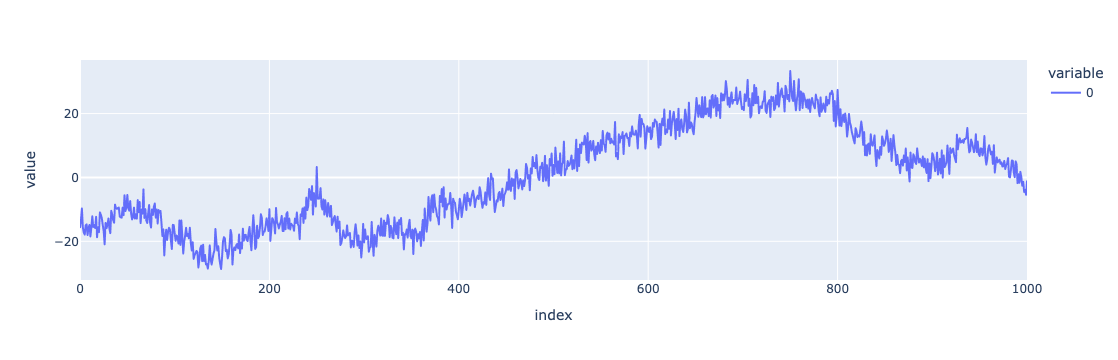

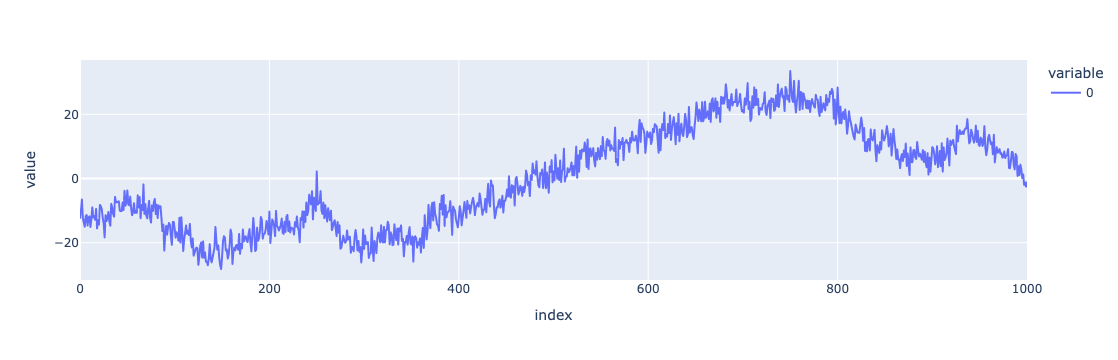

In [79]:
orig_attn_pat = attention_pattern[0, 0, 16, :]
my_attn_pat = attention_pattern[0, 0, 16, :].clone()
my_attn_pat[12:17] = 0
my_attn_pat[0] = 0
my_attn_pat[11] = 0
print(my_attn_pat)

graph_attn_out_diff(orig_attn_pat, my_attn_pat)

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


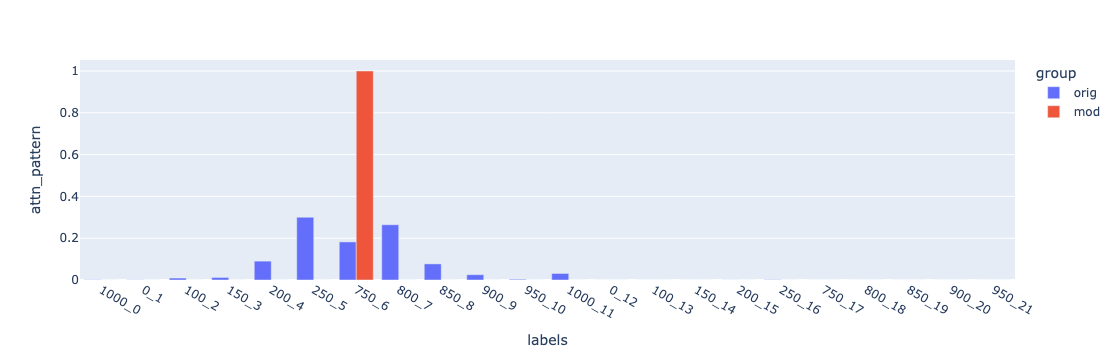

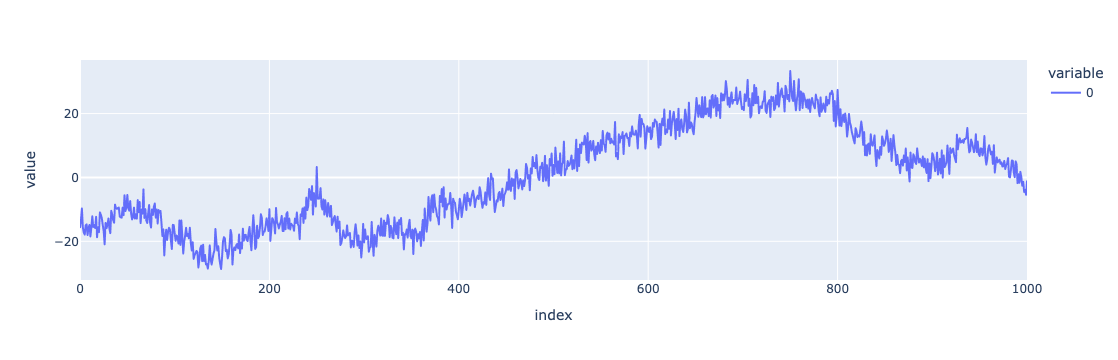

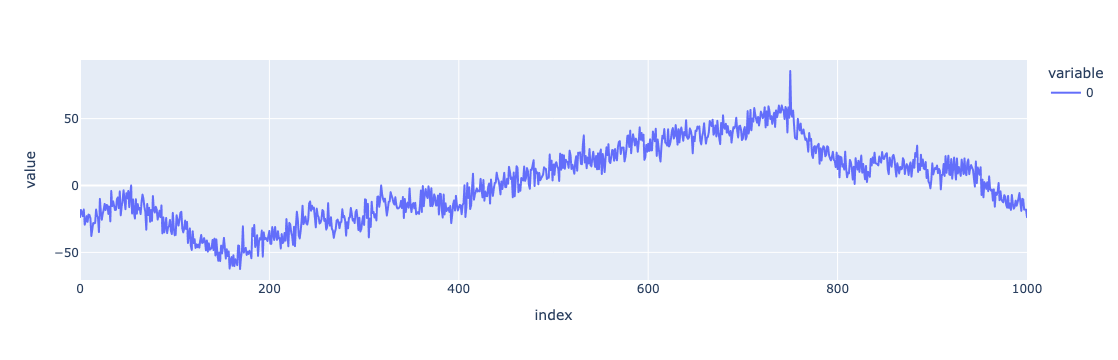

In [80]:
orig_attn_pat = attention_pattern[0, 0, 16, :]
my_attn_pat = attention_pattern[0, 0, 16, :].clone()
my_attn_pat[0] = 0
my_attn_pat[11] = 0
my_attn_pat[:6] = 0
my_attn_pat[:] = 0
my_attn_pat[6] = 1
print(my_attn_pat)

graph_attn_out_diff(orig_attn_pat, my_attn_pat)

Nope... let's try playing with the unsorted tokens

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


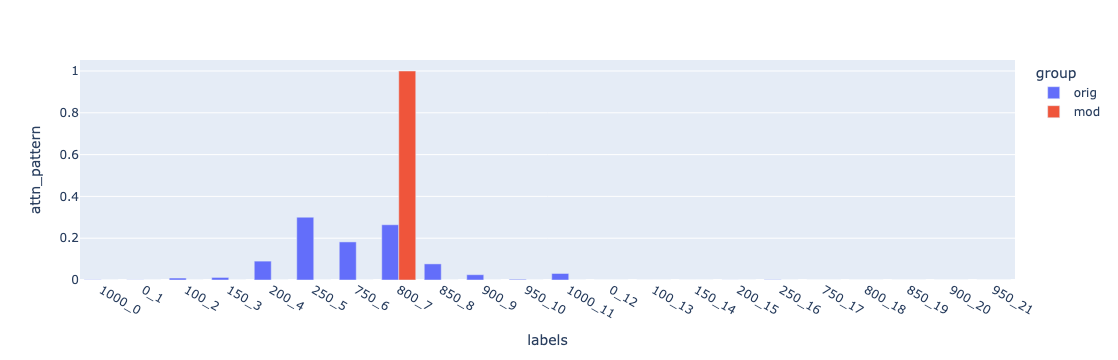

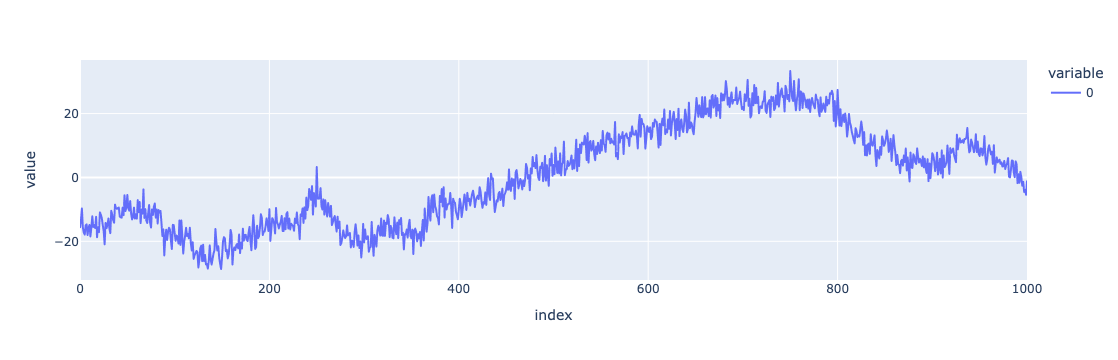

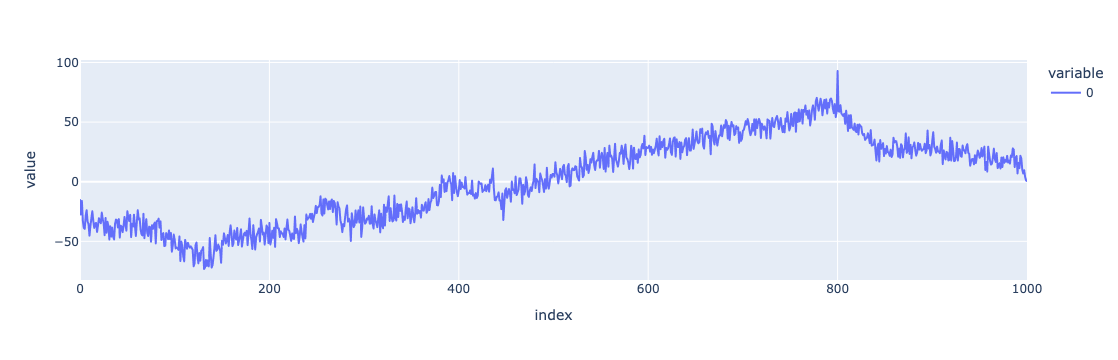

In [81]:
orig_attn_pat = attention_pattern[0, 0, 16, :]
my_attn_pat = attention_pattern[0, 0, 16, :].clone()
my_attn_pat[0] = 0
my_attn_pat[11] = 0
my_attn_pat[:6] = 0
my_attn_pat[:] = 0
my_attn_pat[7] = 1
print(my_attn_pat)

graph_attn_out_diff(orig_attn_pat, my_attn_pat)

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


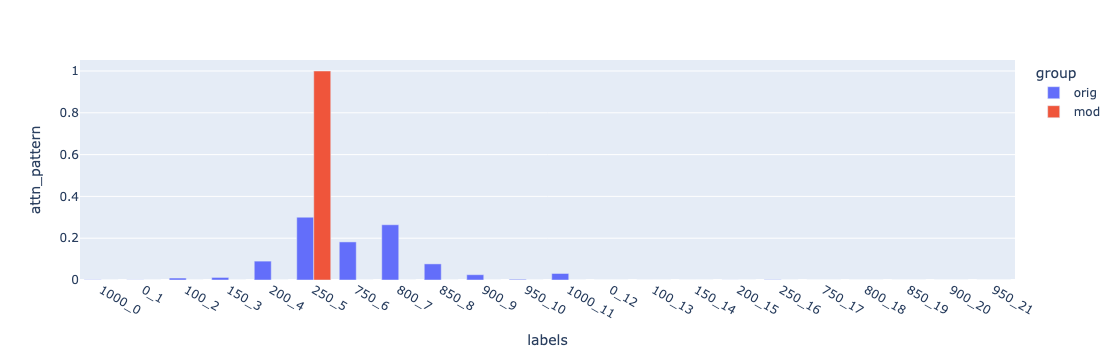

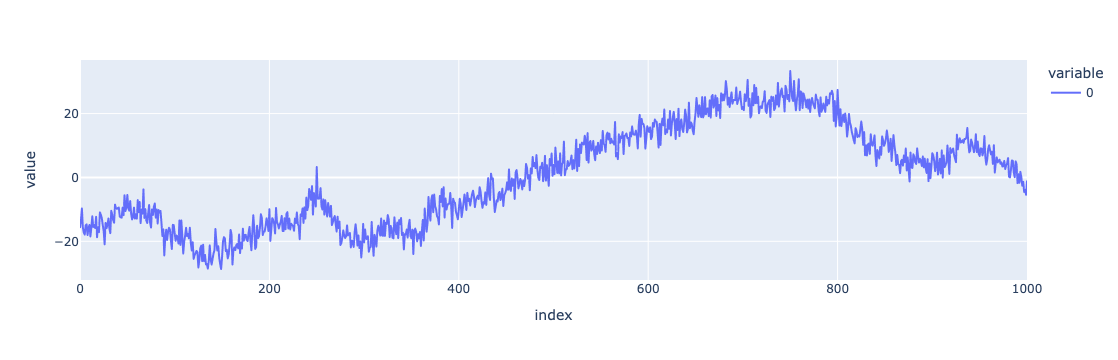

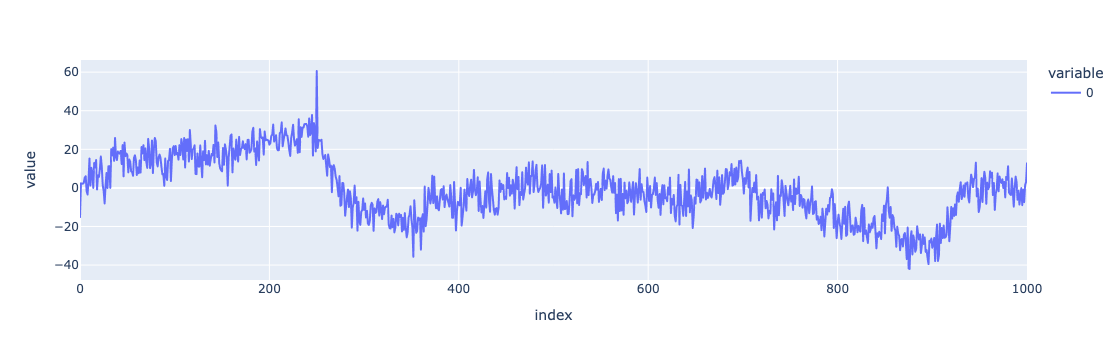

In [82]:
orig_attn_pat = attention_pattern[0, 0, 16, :]
my_attn_pat = attention_pattern[0, 0, 16, :].clone()
my_attn_pat[0] = 0
my_attn_pat[11] = 0
my_attn_pat[:6] = 0
my_attn_pat[:] = 0
my_attn_pat[5] = 1
print(my_attn_pat)

graph_attn_out_diff(orig_attn_pat, my_attn_pat)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])


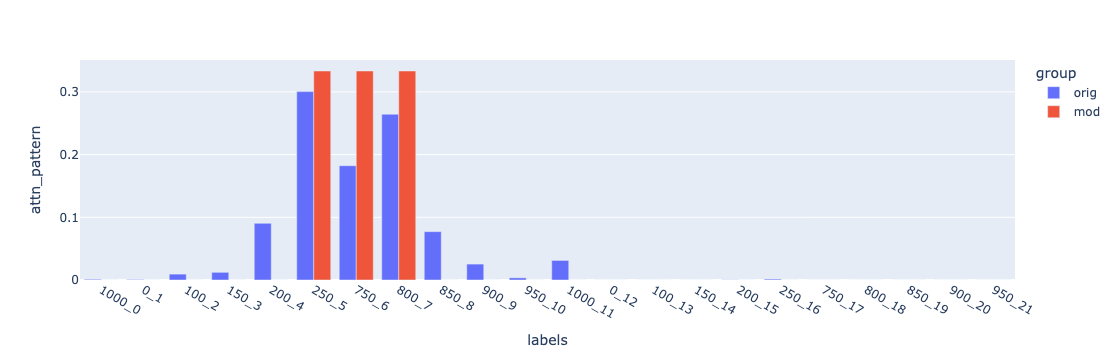

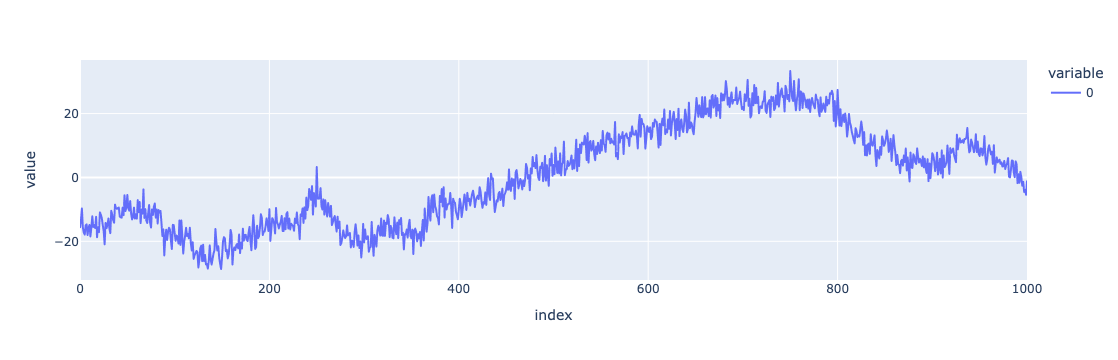

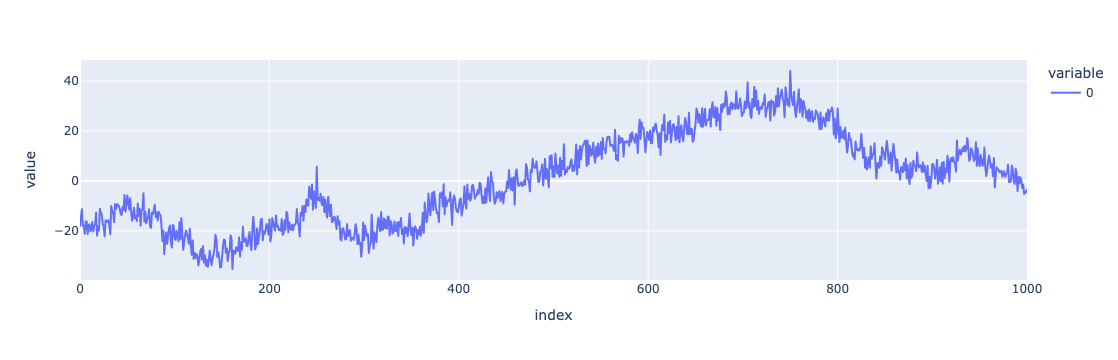

In [83]:
orig_attn_pat = attention_pattern[0, 0, 16, :]
my_attn_pat = attention_pattern[0, 0, 16, :].clone()
my_attn_pat[0] = 0
my_attn_pat[11] = 0
my_attn_pat[:6] = 0
my_attn_pat[:] = 0
my_attn_pat[5:8] = 1/3
print(my_attn_pat)

graph_attn_out_diff(orig_attn_pat, my_attn_pat)

Positional embeddings shouldn't matter a lot for these unsorted tokens, since their unsorted order is random.

What I'm noticing:
- All tokens boost themselves
- High tokens also boost slightly lower tokens and diminish _much lower_ tokens
- Low tokens boost slightly lower tokens and diminish slightly higher tokens

So what's going on w/ 750?
- 250 boosts itself
- 750 boosts itself and diminishes 250
- 800 boosts itself and 750, and diminishes 250
- overall, 250, 750, and 800 predict 750 for the next token

I think attention scores generally favor higher values, especially values near the current token (hence the attending to unsorted self). 750/800 are so high because of softmax.

^ This all feels correct, but are there more rigorous ways to verify?

In [374]:
sort_sequence(hooked_model, seq[12:])

tensor([[1000,    0,  100,  150,  200,  250,  750,  800,  850,  900,  950, 1000,
         1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]])


tensor([  0, 100, 150, 200, 250, 750, 800, 850, 900, 950])